# Final Model Training
The aim of this notebook is to carry out the final model training. For this purpose, the entire training dataset is used, except for the 5% of the data to be used to simulate image ingestion. The model performance is checked on the test dataset and evaluated in detail. 
## 1. Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.onnx

from utils.custom_dataset import CustomFashionMNISTDataset
from utils.train import set_global_seed, train_tuning

# display all rows and columns of pandas DataFrames
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## 2. Load Data

In [2]:
# set a global seed
SEED = 42
set_global_seed(SEED)

In [3]:
%%time
# prepare dataset for the EfficientNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)) 
])

# download test data
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)
print(f"size of the test set: {len(test_dataset)}")

size of the test set: 10000
CPU times: total: 31.2 ms
Wall time: 10.5 ms


In [4]:
%%time
# load training data and labels
data, labels = torch.load("data/fashion_mnist_dataset.pt", weights_only=False)

# split the training set to be able to use some of the data for later image ingestion
print("creating a subset of the training dataset...")
train_data, later_data, train_labels, later_labels = train_test_split(
    data, labels, test_size=0.05, stratify=labels, random_state=42 
)  

# turn data and labels into a dataset format
train_data = CustomFashionMNISTDataset(train_data, train_labels)
print(f"size of the training set: {len(train_data)}")

creating a subset of the training dataset...
size of the training set: 57000
CPU times: total: 2.52 s
Wall time: 7.69 s


## 3. Model Training

In [5]:
# setup device-agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


-----------------------------------
Using config {'batch_size': 32, 'dropout': 0.5, 'epochs': 13, 'learning_rate': 0.001, 'freeze': False} in phase Test


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.5246, Train Acc=0.8088, Train F1=0.8068,Train Precision=0.8061, Train Recall=0.8088
           Test Loss=0.3498, Test Acc=0.8729, Test F1=0.8746, Test Precision=0.8831, Test Recall=0.8729
Epoch 2: Train Loss=0.3005, Train Acc=0.8939, Train F1=0.8934,Train Precision=0.8932, Train Recall=0.8939
           Test Loss=0.2624, Test Acc=0.9043, Test F1=0.9050, Test Precision=0.9098, Test Recall=0.9043
Epoch 3: Train Loss=0.2528, Train Acc=0.9093, Train F1=0.9090,Train Precision=0.9088, Train Recall=0.9093
           Test Loss=0.2572, Test Acc=0.9120, Test F1=0.9105, Test Precision=0.9144, Test Recall=0.9120
Epoch 4: Train Loss=0.2264, Train Acc=0.9193, Train F1=0.9190,Train Precision=0.9189, Train Recall=0.9193
           Test Loss=0.2061, Test Acc=0.9259, Test F1=0.9252, Test Precision=0.9260, Test Recall=0.9259
Epoch 5: Train Loss=0.2040, Train Acc=0.9271, Train F1=0.9270,Train Precision=0.9269, Train Recall=0.9271
           Test Loss=0.2183, Test Acc=0.9258, Test F1=

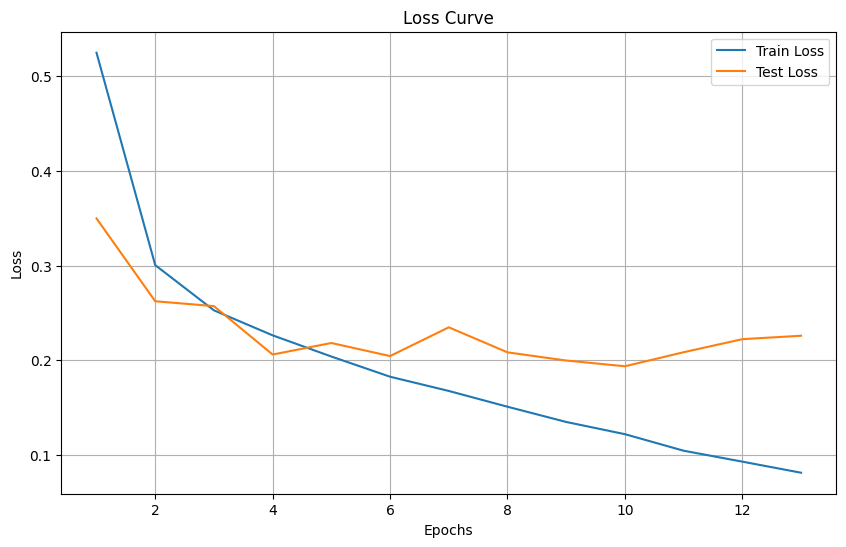

In [6]:
# best hyperparameter combination
config = {
    "batch_size": 32,
    "dropout": 0.5,
    "epochs": 13,  
    "learning_rate": 0.001,
    "freeze": False
}

# perform model training
model = train_tuning(config, device, train_data, test_dataset, phase="Test")

## 4. Model Evaluation

In [7]:
# use the model to make predictions for the test dataset
model.eval()
all_preds = []
all_labels = []

test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

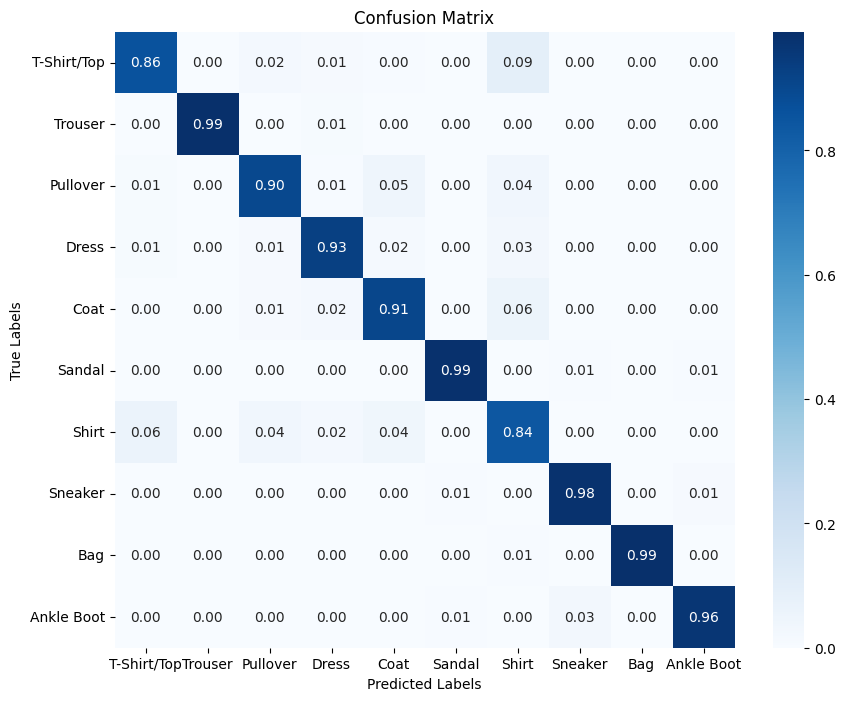

In [8]:
# define the class names
class_names = [
    "T-Shirt/Top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]

# plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds, normalize="true")
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [9]:
# generate the classification report
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

# convert to DataFrame
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
T-Shirt/Top,0.915868,0.8600,0.887055,1000.0000
Trouser,0.992972,0.9890,0.990982,1000.0000
Pullover,0.917347,0.8990,0.908081,1000.0000
Dress,0.927291,0.9310,0.929142,1000.0000
Coat,0.891176,0.9090,0.900000,1000.0000
Sandal,0.987988,0.9870,0.987494,1000.0000
Shirt,0.791157,0.8410,0.815317,1000.0000
Sneaker,0.965619,0.9830,0.974232,1000.0000
Bag,0.991992,0.9910,0.991496,1000.0000
Ankle Boot,0.981670,0.9640,0.972755,1000.0000


## 5. Save the Trained Model

In [10]:
# save the trained model as PyTorch state dictionary
filename = f"trained_enet_0"
torch.save(model, f"trained_models/{filename}.pth")
print(f"model saved to {filename}.pth.")

model saved to trained_enet_0.pth.


In [11]:
# move the model to the cpu
model.cpu()

# define the onnx path
onnx_path = f"trained_models/{filename}.onnx"

# set batch_size to None (dynamic)
dynamic_axes = {"input": {0: "batch_size"}, "output": {0: "batch_size"}}
dummy_input = torch.randn(1, 1, 224, 224, device="cpu")

# export the trained model to ONNX
torch.onnx.export(
    model, 
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version = 11,
    do_constant_folding=True,  # optimizes the model (less computing effort)
    input_names=["input"],
    output_names=["output"],
    dynamic_axes=dynamic_axes  # set dynamic batch size
)
print(f"model exported to {onnx_path}.")

model exported to trained_models/trained_enet_0.onnx.
